# Voice-Driven Disease Classification: A Deep Learning Approach


In [1]:
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import TensorDataset, DataLoader


import os
from tqdm import tqdm
import IPython.display as ipd


import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


from model.classifier import Classifier
from model.conv_net import M5
from transformers import BertModel, BertTokenizer

%load_ext autoreload
%autoreload 2

In [2]:
record_df = pd.read_csv("./data/overview-of-recordings.csv")

# print the number of recordings
print("Number of recordings: ", len(record_df))
print("Number of features: ", len(record_df.columns))

Number of recordings:  6661
Number of features:  13


In [3]:
# check if we have the same number of audio files (.wav) as we have rows in the dataframe
data_dir = "./data/recordings"
nb_training_samples = len(os.listdir(os.path.join(data_dir, "train")))
nb_validation_samples = len(os.listdir(os.path.join(data_dir, "validate")))
nb_test_samples = len(os.listdir(os.path.join(data_dir, "test")))
print("Number of training samples: ", nb_training_samples)
print("Number of validation samples: ", nb_validation_samples)
print("Number of test samples: ", nb_test_samples)
print("Total number of samples: ", nb_training_samples + nb_test_samples + nb_validation_samples)


Number of training samples:  381
Number of validation samples:  385
Number of test samples:  5895
Total number of samples:  6661


### Add a column to indicate if the record is in the training set, validation set, or test set 


In [4]:
train_files = set(os.listdir(os.path.join(data_dir, "train")))
valid_files = set(os.listdir(os.path.join(data_dir, "validate")))
test_files = set(os.listdir(os.path.join(data_dir, "test")))

record_df["split"] = record_df["file_name"].apply(lambda x: "train" if x in train_files else ("validate" if x in valid_files else "test"))

# check if the numbers corresponds to the previous numbers
print("Number of training samples: ", len(record_df[record_df.split == "train"]))
print("Number of validation samples: ", len(record_df[record_df.split == "validate"]))
print("Number of test samples: ", len(record_df[record_df.split == "test"]))

record_df.head(2)

Number of training samples:  381
Number of validation samples:  385
Number of test samples:  5895


,audio_clipping,audio_clipping:confidence,background_noise_audible,background_noise_audible:confidence,overall_quality_of_the_audio,quiet_speaker,quiet_speaker:confidence,speaker_id,file_download,file_name,phrase,prompt,writer_id,split
0,no_clipping,1.0000,light_noise,1.0000,3.33,audible_speaker,1.0,43453425,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43453425_58166571.wav,When I remember her I feel down,Emotional pain,21665495,test
1,light_clipping,0.6803,no_noise,0.6803,3.33,audible_speaker,1.0,43719934,https://ml.sandbox.cf3.us/cgi-bin/index.cgi?do...,1249120_43719934_43347848.wav,When I carry heavy things I feel like breaking...,Hair falling out,44088126,test


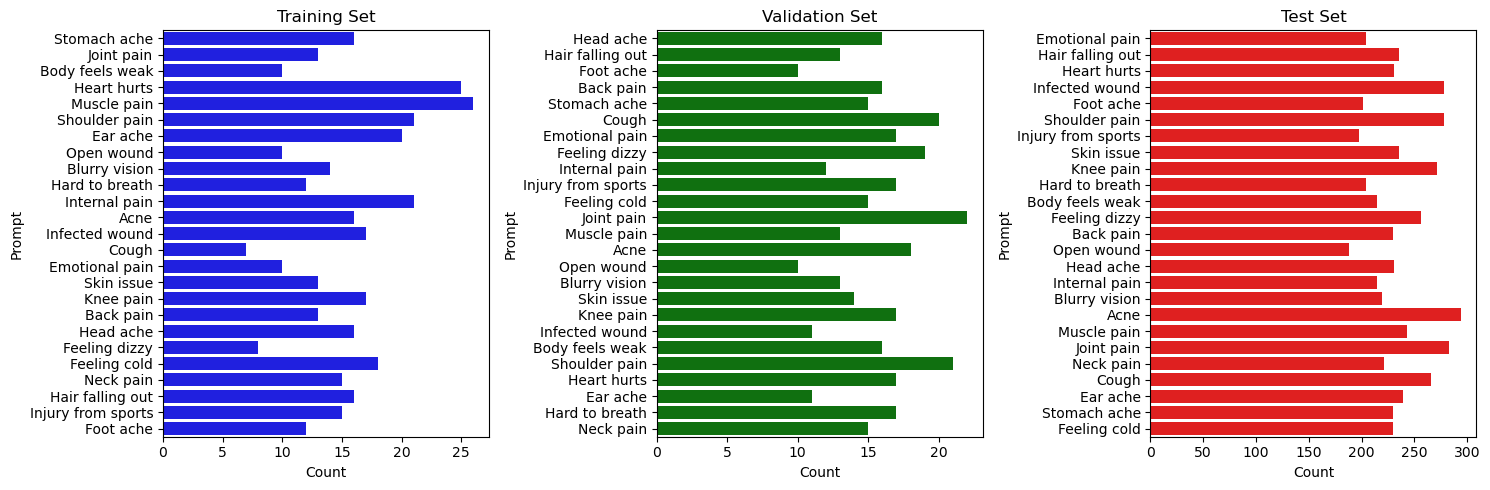

In [5]:
# Filter data for each split
train_df = record_df[record_df['split'] == 'train']
valid_df = record_df[record_df['split'] == 'validate']
test_df = record_df[record_df['split'] == 'test']

# Create Seaborn count plot
def create_count_plot(ax, df, title, color):
    sns.countplot(y='prompt', data=df, color=color, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Count')
    ax.set_ylabel('Prompt')

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figure size as needed

# Combine the count plots on the same row
create_count_plot(axes[0], train_df, 'Training Set', 'blue')
create_count_plot(axes[1], valid_df, 'Validation Set', 'green')
create_count_plot(axes[2], test_df, 'Test Set', 'red')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [6]:
# create dictionnary to map each prompt to a number
prompt_to_id = {prompt: i for i, prompt in enumerate(record_df.prompt.unique())}
prompt_to_id

{'Emotional pain': 0,
 'Hair falling out': 1,
 'Heart hurts': 2,
 'Infected wound': 3,
 'Foot ache': 4,
 'Shoulder pain': 5,
 'Injury from sports': 6,
 'Skin issue': 7,
 'Stomach ache': 8,
 'Knee pain': 9,
 'Joint pain': 10,
 'Hard to breath': 11,
 'Head ache': 12,
 'Body feels weak': 13,
 'Feeling dizzy': 14,
 'Back pain': 15,
 'Open wound': 16,
 'Internal pain': 17,
 'Blurry vision': 18,
 'Acne': 19,
 'Muscle pain': 20,
 'Neck pain': 21,
 'Cough': 22,
 'Ear ache': 23,
 'Feeling cold': 24}

### Get the audio data with the metadata


### Keep the records with audio quality >= 3.5


In [7]:
clean_audio_df = record_df[record_df.overall_quality_of_the_audio >= 3.5]

print("Number of training samples: ", len(clean_audio_df[clean_audio_df.split == "train"]))
print("Number of validation samples: ", len(clean_audio_df[clean_audio_df.split == "validate"]))
print("Number of test samples: ", len(clean_audio_df[clean_audio_df.split == "test"]))

Number of training samples:  269
Number of validation samples:  192
Number of test samples:  4018


### First idea : analyze the waveform


The waveforms has 2 channels (left and right). We can only both or use the mean of both channels. 


Let's use the mean for convenience to start 


In [8]:

def process_audio_files(data_path, new_sample_rate=8000):
    waveforms = []
    labels = []

    for file in tqdm(os.listdir(data_path)):
        prompt = clean_audio_df[clean_audio_df["file_name"] == file].prompt
        # check if the prompt is empty (if yes it means that the file is not in the clean_audio_df dataframe)
        if prompt.shape[0] == 0:
            continue

        label = prompt_to_id[prompt.values[0]]
        waveform, sample_rate = torchaudio.load(os.path.join(data_path, file))
        mean_waveform = torch.mean(waveform, dim=0, keepdim=True)

        transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
        transformed = transform(mean_waveform).squeeze(0)

        waveforms.append(transformed)
        labels.append(label)

    # pad the waveforms to have the same length
    padded_waveforms = nn.utils.rnn.pad_sequence(waveforms, batch_first=True)
    tensor_labels = torch.tensor(labels)

    return padded_waveforms, tensor_labels

In [9]:
record_path = "./data/recordings"

train_waveforms, train_labels = process_audio_files(os.path.join(record_path, "train"))
valid_waveforms, valid_labels = process_audio_files(os.path.join(record_path, "validate"))
test_waveforms, test_labels = process_audio_files(os.path.join(record_path, "test"))

# create DataLoader
train_dataset = TensorDataset(train_waveforms, train_labels)
valid_dataset = TensorDataset(valid_waveforms, valid_labels)
test_dataset = TensorDataset(test_waveforms, test_labels)

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


100%|██████████| 5895/5895 [00:33<00:00, 175.09it/s]


In [13]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model = M5(n_input=1, n_output=len(prompt_to_id)).to(device)

# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.00001)

# train the model
cnn_model.train()
epochs = 50

train_losses = []
valid_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    # !! Note : Again we use the test to train 
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)
        
        optimizer.zero_grad()

        outputs = cnn_model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    train_losses.append(running_loss / len(test_dataloader))
    
    # evaluate the model
    cnn_model.eval()
    running_loss = 0.0
    correct = 0
    total_samples = 0
    for i, data in enumerate(valid_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)

        outputs = cnn_model(inputs)
        outputs = outputs.squeeze(1)
        predictions = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        
        # calculate the accuracy
        correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        
    valid_losses.append(running_loss / len(valid_dataloader))
    acc = correct / total_samples
    cnn_model.train()
    
    print(f"Epoch {epoch+1} - Training loss: {train_losses[-1]:.3f} - Validation loss: {valid_losses[-1]:.3f} - Validation acc: {acc*100:.3f} %")

print('Finished Training')

Epoch 1 - Training loss: 3.278 - Validation loss: 3.252 - Validation acc: 2.604 %
Epoch 2 - Training loss: 3.267 - Validation loss: 3.303 - Validation acc: 4.167 %
Epoch 3 - Training loss: 3.259 - Validation loss: 3.298 - Validation acc: 4.167 %
Epoch 4 - Training loss: 3.253 - Validation loss: 3.291 - Validation acc: 5.208 %
Epoch 5 - Training loss: 3.247 - Validation loss: 3.286 - Validation acc: 5.208 %
Epoch 6 - Training loss: 3.242 - Validation loss: 3.278 - Validation acc: 5.208 %
Epoch 7 - Training loss: 3.238 - Validation loss: 3.269 - Validation acc: 4.688 %
Epoch 8 - Training loss: 3.235 - Validation loss: 3.265 - Validation acc: 5.208 %
Epoch 9 - Training loss: 3.232 - Validation loss: 3.266 - Validation acc: 5.729 %
Epoch 10 - Training loss: 3.228 - Validation loss: 3.267 - Validation acc: 5.729 %
Epoch 11 - Training loss: 3.227 - Validation loss: 3.260 - Validation acc: 5.208 %
Epoch 12 - Training loss: 3.225 - Validation loss: 3.262 - Validation acc: 5.729 %
Epoch 13 - Tr

In [32]:
for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)
        

        outputs = cnn_model(inputs)
        outputs = outputs.squeeze(1)
        predictions = torch.argmax(outputs, dim=1)
        
        # print the predicted and true labels for the first batch
        print((predictions == labels).sum().item())
        break

3


### Second idea : Use the phrase from the metadata


Use a pre trained transformer model to get the embeddings of the phrase 


Create and save the embeddings for the phrases in the metadata


In [ ]:
save_path_embedd = "./data/embeddings"
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = BertModel.from_pretrained('bert-large-uncased')

In [ ]:
for idx, row in tqdm(record_df.iterrows(), total=len(record_df)):
    # save path for the embedding
    save_path = os.path.join(save_path_embedd, row.split, row.file_name.replace(".wav", ".pt"))
    sentence = row.phrase
    tokenized_text = tokenizer.tokenize(sentence)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    model.eval()
    # Get hidden states
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs.last_hidden_state

    # take the mean of the embeddings over the whole sentence
    sentence_embedding = torch.mean(hidden_states[0], dim=0)
    
    # !! NOTE: we add the label at the end of the embedding (hence 768 for the embedding size and 1 for the label)
    sentence_embedding_with_label = torch.cat((sentence_embedding, torch.tensor([prompt_to_id[row.prompt]])))
    
    # save the embedding
    torch.save(sentence_embedding_with_label, save_path)

In [ ]:
def load_embeddings(path):
    embeddings_list = []
    labels_list = []
    for file in tqdm(os.listdir(path)):
        embedding_with_label = torch.load(os.path.join(path, file))
        embedding = embedding_with_label[:-1]
        label = embedding_with_label[-1]
        embeddings_list.append(embedding)
        labels_list.append(label)
    return torch.stack(embeddings_list), torch.stack(labels_list)

train_embeddings, train_labels = load_embeddings(os.path.join(save_path_embedd, "train"))
valid_embeddings, valid_labels = load_embeddings(os.path.join(save_path_embedd, "validate"))
test_embeddings, test_labels = load_embeddings(os.path.join(save_path_embedd, "test"))
print("Train embeddings shape: ", train_embeddings.shape, "Train labels shape: ", train_labels.shape)
print("Valid embeddings shape: ", valid_embeddings.shape, "Valid labels shape: ", valid_labels.shape)
print("Test embeddings shape: ", test_embeddings.shape, "Test labels shape: ", test_labels.shape)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = Classifier(train_embeddings.shape[1], len(prompt_to_id)).to(device)	

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0001)

# Training loop
num_epochs = 5000
train_losses = []
valid_losses = []

# !! NOTE : use the validation and train set to evaluate the model
valid_embeddings = torch.cat((valid_embeddings, train_embeddings))
valid_labels = torch.cat((valid_labels, train_labels))

for epoch in range(num_epochs):
    # Training
    classifier.train()
    # !! NOTE: In this case, we use the test set as training set since it is bigger  
    inputs, targets = test_embeddings.to(device), test_labels.to(device, dtype=torch.long)
    outputs = classifier(inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss = loss.item()
    train_losses.append(train_loss)

    classifier.eval()
    with torch.no_grad():
        inputs, targets = valid_embeddings.to(device), valid_labels.to(device, dtype=torch.long)
        outputs = classifier(inputs)
        loss = criterion(outputs, targets)
        valid_loss = loss.item()
        valid_losses.append(valid_loss)
        accuracy = torch.mean((torch.argmax(outputs, dim=1) == targets).float())

    if epoch % 50 == 0:
        print("Epoch:", "%04d" % (epoch + 1), "train cost =", "{:.6f}".format(train_loss), "valid cost =", "{:.6f}".format(valid_loss), "valid accuracy =", "{:.2f}".format(accuracy * 100.0))

# Plot the train and validation losses
plt.plot(train_losses, label='Train loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend()
plt.show()

In [ ]:
# create confusion matrix for the valid set
classifier.eval()
with torch.no_grad():
    inputs, targets = valid_embeddings.to(device), valid_labels.to(device, dtype=torch.long)
    outputs = classifier(inputs)
    predictions = torch.argmax(outputs, dim=1)
    accuracy = torch.mean((predictions == targets).float())
    print("Test accuracy: ", accuracy.item())

    # Create confusion matrix
    confusion_matrix = torch.zeros(len(prompt_to_id), len(prompt_to_id))
    for t, p in zip(targets, predictions):
        confusion_matrix[t, p] += 1

    # Normalize confusion matrix
    confusion_matrix = confusion_matrix / confusion_matrix.sum(dim=1, keepdim=True)

    # Create a figure
    plt.figure(figsize=(5, 5))
    # Show confusion matrix
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.xticks(range(len(prompt_to_id)), prompt_to_id.keys(), rotation=90)
    plt.yticks(range(len(prompt_to_id)), prompt_to_id.keys())
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.colorbar()

    # Add text annotations for non-zero misclassified data
    for i in range(len(prompt_to_id)):
        for j in range(len(prompt_to_id)):
            value = confusion_matrix[i, j]
            if value != 0:
                text = plt.text(j, i, f'{value:.2f}', ha='center', va='center', color='green')
                # Highlight misclassified data
                if i != j:
                    text.set_color("red")
                    text.set_weight('bold')

    plt.show()

In [ ]:
# test the model using sentences generated by ChatGPT
sentences = ["I have headache"]
acc = 0 
labels = prompt_to_id.values()
for sentence, label in zip(sentences, labels):
    tokenized_text = tokenizer.tokenize(sentence)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    model.eval()
    # Get hidden states
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs.last_hidden_state

    # take the mean of the embeddings over the whole sentence
    sentence_embedding = torch.mean(hidden_states[0], dim=0)

    # classify the sentence
    classifier.eval()
    with torch.no_grad():
        inputs = sentence_embedding.to(device)
        inputs = inputs.unsqueeze(0)
        outputs = classifier(inputs)
        prediction = torch.argmax(outputs, dim=1)
        predicted_prompt = list(prompt_to_id.keys())[prediction.item()]
     
    # print("Label: ", label)
    print("Predicted prompt: ", predicted_prompt)
    print("--------------------------------------------------")
    print("\n")
    # acc += label == predicted_prompt
    
# print("Accuracy: ", acc / len(sentences), " %")

### Compare both 


### Use a combination of both
